In [1]:
# VER README
# Notebooks con Markdown en celdas de código para renderizar a pdf sin celdas input ni prompt

import math
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sympy import *
from IPython.display import Markdown as md

%matplotlib inline

# Data
DATA_PATH = "data/"

# Funciones
rnd = lambda x: round(x, 2)

# Caracterización de un contador Geiger-Muller

Se realizan una serie de medidas en el laboratorio con la idea de hacer la caracterización de un contador Geiger-Muller (G-M).

## Curva característica

En primer lugar se mide la actividad de una muestra radiactiva de $Co^{60}$ y $Sr^{90}$ variando la tensión de entrada.

In [2]:
# Datos curva característica

# fuente: cobalto 60
# tiempo de medida: 90s
t_p1 = 90
# medidas: practica1_curva.csv donde columnas son la tensión en voltios y el número de cuentas
data1_p1 = DATA_PATH + "practica1_curva.csv"
df1_p1 = pd.read_csv(data1_p1)
df1_p1["bq"] = df1_p1["cuentas"]/t_p1
#df1_p1.style
print(tabulate(df1_p1, headers="keys", tablefmt="presto", showindex=False))

   tension (V) |   cuentas |        bq
---------------+-----------+-----------
           360 |        85 |  0.944444
           400 |      2099 | 23.3222
           440 |      4232 | 47.0222
           480 |      4187 | 46.5222
           520 |      4352 | 48.3556
           560 |      4265 | 47.3889
           600 |      4260 | 47.3333
           640 |      4393 | 48.8111
           680 |      4438 | 49.3111
           720 |      4451 | 49.4556
           760 |      4508 | 50.0889
           800 |      4724 | 52.4889
           840 |      4914 | 54.6
           880 |      5292 | 58.8


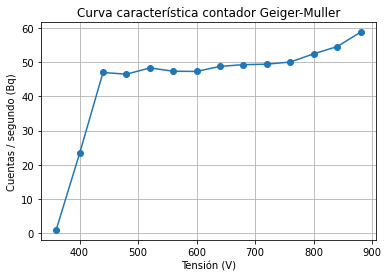

In [3]:
plt.plot(df1_p1["tension (V)"], df1_p1["bq"], "-o")
#plt.legend(loc="top_right")
plt.title("Curva característica contador Geiger-Muller")
plt.xlabel("Tensión (V)")
plt.ylabel("Cuentas / segundo (Bq)")
plt.grid(True)
plt.show()

In [4]:
V_u = df1_p1["tension (V)"][2]
V_i = df1_p1["tension (V)"][3]
V_f = df1_p1["tension (V)"][10]
l_meseta = V_f-V_i
V_t = df1_p1["tension (V)"][3] + 100
R_i = round(df1_p1["bq"][3], 2)
R_f = round(df1_p1["bq"][10], 2)

TEXT = f"Por inspección visual podemos ver que la tensión umbral viene dada por el valor $V_u={V_u}V$. \
         La longitud de la meseta en este caso sería $V_f - V_i = {V_f} - {V_i} = {l_meseta}V$, \
         siendo $V_f$ y $V_i$ la tensión al comienzo y al final de la meseta.\
         \
         Puesto que la longitud de la meseta es superior a 200V tenemos que la tensión de trabajo es $V_t = V_i + 100 ={V_t}V$"

md(TEXT)

Por inspección visual podemos ver que la tensión umbral viene dada por el valor $V_u=440V$.          La longitud de la meseta en este caso sería $V_f - V_i = 760 - 480 = 280V$,          siendo $V_f$ y $V_i$ la tensión al comienzo y al final de la meseta.                  Puesto que la longitud de la meseta es superior a 200V tenemos que la tensión de trabajo es $V_t = V_i + 100 =580V$

La pendiente relativa al punto medio de la meseta expresada en tanto por ciento por 100V viene data por la expresión
$$
P = \frac{\frac{R_f - R_i}{(R_f + R_i)/2}}{(V_f - V_i)/100}100
$$

In [5]:
P = 100 * ((R_f - R_i) / ((R_f + R_i)/2)) / ((V_f - V_i)/100)
P = rnd(P)

TEXT = f"Siendo $R_i = {R_i}$, $R_f={R_f}$ los Bq al comienzo y final de la meseta, respectivamente. \
         Con estos datos obtenemos un valor de $P={P}$ en % (por 100V)"

md(TEXT)

Siendo $R_i = 46.52$, $R_f=50.09$ los Bq al comienzo y final de la meseta, respectivamente.          Con estos datos obtenemos un valor de $P=2.64$ en % (por 100V)

## Fondo

Mediante el método de las dos fuentes podemos calcular el tiempo de resolución del contador Geiger-Muller. Si se mide durante 90s la actividad de una muestra de $Co^{60}$ y $Sr^{90}$, obtenemos la siguiente tabla

In [6]:
# Datos detección de fondo

# fuente: cobalto 60, estroncio 90
# tiempo de medida: 90s
t_p1 = 90
# medidas: practica1_fondo.csv
data2_p1 = DATA_PATH + "practica1_fondo.csv"
df2_p1 = pd.read_csv(data2_p1, index_col="cuentas")
df2_p1 = df2_p1.T

df2_p1["media"] = df2_p1.mean(axis=1)
df2_p1["bq"] = df2_p1["media"]/t_p1
df2_p1["bq"] = df2_p1["bq"].map(rnd)
print(tabulate(df2_p1, headers="keys", tablefmt="presto"))

     |    0 |    1 |    2 |    3 |   media |    bq
-----+------+------+------+------+---------+-------
 A1  | 4036 | 4110 | 4096 | 4082 | 4081    | 45.34
 A12 | 7577 | 7545 | 7630 | 7433 | 7546.25 | 83.85
 A2  | 3750 | 3806 | 3833 | 3819 | 3802    | 42.24
 F   |   27 |   14 |   30 |   29 |   25    |  0.28


Donde $A_1$ corresponde a la actividad de la muestra de cobalto, $A_2$ a la muestra de estroncio, $A_{12}$ la actividad de ambas muestras y $F$ la radiación de fondo (sin muestra). Con estas medidas podemos calcular el tiempo de resolución del contador mediante la siguiente fórmula

$$
\tau = \frac{A_{12} + F - A_1 - A_2}{A_1^2 + A_2^2 - F^2 - A_{12}^2}
$$

In [7]:
A1 = df2_p1["bq"]["A1"]
A12 = df2_p1["bq"]["A12"]
A2 = df2_p1["bq"]["A2"]
F = df2_p1["bq"]["F"]

tau = (A12+F-A1-A2) / ((A1*A1) + (A2*A2) - (F*F) - (A12*A12))

TEXT = f"Sustituyendo valores obtenemos que el tiempo de resolución es ${round(tau, 4)}s$"

md(TEXT)

Sustituyendo valores obtenemos que el tiempo de resolución es $0.0011s$

## Eficiencia del detector

In [8]:
# Datos Cobalto 60
L_co = 4537 # número de cuentas (dato)
# F # fondo (cuentas)
tasa_recuento_neta_co = (L_co-F)/t_p1 # bq
actividad_inicial_co = 37000 # bq
tiempo_medicion_co = 1.92 # años, abril 2010 a marzo 2012
periodo_co = 5.26 # años
lambda_co = np.log(2)/periodo_co # años^(-1)
actividad_corregida_co = actividad_inicial_co*np.e**(-lambda_co*tiempo_medicion_co) # bq
epsilon_co = tasa_recuento_neta_co/actividad_corregida_co


**Fuente: $Co^{60}$**

- Tipo de emisión: emisión $\beta^{-}$ y $\gamma$

- Tiempo de medida: $t=90s$

- Número de cuentas: $L=4537$

- Fondo: $F = 25$

- Tasa de recuento neta: $A'= \frac{(L-F)}{t} = 50.13 Bq$

- Actividad inicial de la muestra: $A_0 = 1 \mu Ci = 37000 Bq$

- Fecha: abril 2010. Tiempo transcurrido hasta marzo 2012 cuando fueron tomadas las medidas: $T_m = 23 meses (1.92 a)$

- Período: $T_{1/2} = 5.26 a -> \lambda = \frac{ln2}{T_{1/2}} = 0.13 a^{-1}$

- Actividad corregida: $A = A_0e^{- \lambda T_m} = 28728 Bq$

- Eficiencia $\epsilon = A'/A = 0.0018$

In [9]:
# Datos Estroncio 90
L_sr = 34212 # número de cuentas (dato)
# F # fondo (cuentas)
tasa_recuento_neta_sr = (L_sr-F)/t_p1 # bq
actividad_inicial_sr = 3700 # bq
tiempo_medicion_sr = 1.83 # años, mayo 2010 a marzo 2012
periodo_sr = 28.5 # años
lambda_sr = np.log(2)/periodo_sr # años^(-1)
actividad_corregida_sr = actividad_inicial_sr*np.e**(-lambda_sr*tiempo_medicion_sr) # bq
epsilon_sr = tasa_recuento_neta_sr/actividad_corregida_sr


**Fuente: $Sr^{90}$**

- Tipo de emisión: emisión $\beta^{-}$

- Tiempo de medida: $t=90s$

- Número de cuentas: $L=34212$

- Fondo: $F = 25$

- Tasa de recuento neta: $A'= \frac{(L-F)}{t} = 380.13 Bq$

- Actividad inicial de la muestra: $A_0 = 0.1 \mu Ci = 3700 Bq$

- Fecha: mayo 2010. Tiempo transcurrido hasta marzo 2012 cuando fueron tomadas las medidas: $T_m = 22 meses (1.83 a)$

- Período: $T_{1/2} = 28.5 a -> \lambda = \frac{ln2}{T_{1/2}} = 0.024 a^{-1}$

- Actividad corregida: $A = A_0e^{- \lambda T_m} = 3538.93 Bq$

- Eficiencia $\epsilon = A'/A = 0.11$

## Conclusiones

La construcción de la curva característica de un detector Geiger-Muller permite determinar el potencial óptimo de trabajo del dispositivo.

La pendiente de la meseta de un detector Geiger ordinario suele estar entorno al 2%-3%, resultado que concuerda en gran medida con el valor hallado en este experimento (2.64%).

En cuanto al tiempo de respuesta de nuestro detector, podemos decir que es de respuesta lenta $\tau = 0.0011s$, ya que existen detectores con un tiempo de resolución del microsegundo. 

Es importante recalcar que conservar la posición de las muestras a lo largo del experimento es importante puesto que la eficiencia del detector, en especial la eficiencia geométrica, depende de la distancia a la fuente de partículas. En cuanto a la eficiencia según el tipo de fuente emisora, tenemos dos casos por analizar:

- Radiación gamma $\gamma$: al ser radiación de alta energía tenemos que la mayoría de los fotones emitidos atraviesan el contador con mínima interacción. Cabe preguntarse si nuestro detector cumple los estándares habituales. Dado que los detectores G-M para la radiación gamma suelen tener una eficiencia de entorno al 1% (o incluso menor) podemos concluir que nuestro detector sigue dicha normalidad, pues el valor obtenido es de entorno al $\epsilon = 0.18$ %

- Radiación beta $\beta$: los contadores G-M se caracterizan por ser buenos detectores de este tipo de radiación (corto alcance), por lo que suelen tener eficiencias muy cercanas al 100%, sin embargo, nuestro detector G-M ofrece una eficiencia de entorno al 11%, con lo que no podemos concluir que sea especialmente bueno para este tipo de radiación (al contrario que con la radiación gamma).

Por ahora hemos analizado la eficiencia del detector G-M según el tipo de radiación, pero es importante aclarar que la eficiencia absoluta no solo depende de este factor sino que también de factores geométricos (como ya hemos comentado anteriormente sobre la posición de las partículas). La relación entre las distintas eficiencias que puede resumirse según la fórmula $\epsilon_t = \epsilon_{geo} x \epsilon_{i}$, y aquí intervienen factores que pueden ser muy determinantes como son la energía de la radiación, la probabilidad de interacción en el detector, el tiempo de respuesta del detector, sus materiales de fabricación, su tamaño, etc.

Con todo lo dicho anteriormente, y teniendo en cueta las medidas tomadas y los cálculos realizados, podemos llegar a la conclusión de que hemos realizado una correcta caracterización de nuestro detector G-M.

# Estadística aplicada a medidas nucleares

Usaremos el detector G-M de la práctica anterior para medir la actividad de una muestra de $Sr^{90}$. Los datos recogidos son los siguientes

In [10]:
# Datos estadítica aplicada
# medidas: practica2_sr.csv donde columnas son el número de medida y el número de cuentas
data1_p2 = DATA_PATH + "practica2_sr.csv"
df1_p2 = pd.read_csv(data1_p2, index_col="medida")
#df1_p1.style
print(tabulate(df1_p2, headers="keys", tablefmt="presto"))

   medida |   cuentas
----------+-----------
        1 |      3736
        2 |      3847
        3 |      3758
        4 |      3706
        5 |      3785
        6 |      3802
        7 |      3708
        8 |      3761
        9 |      3779
       10 |      3800
       11 |      3704
       12 |      3812
       13 |      3685
       14 |      3760
       15 |      3641
       16 |      3703
       17 |      3541
       18 |      3746
       19 |      3659
       20 |      3581
       21 |      3735
       22 |      3794
       23 |      3684
       24 |      3748
       25 |      3793
       26 |      3776
       27 |      3721
       28 |      3766
       29 |      3809
       30 |      3735


In [11]:
# sum([n for n in df1_p2["cuentas"]])/30 == df1_p2["cuentas"].mean()

N = len(df1_p2) # número de intervalos
f = N-1
n = df1_p2["cuentas"].mean() # sum([n for n in df1_p2["cuentas"]])/30 == df1_p2["cuentas"].mean()
s_t = math.sqrt(n) # desviación típica teórica
s_exp = df1_p2["cuentas"].std() # desviación típica experimental
# s_exp = np.std(df1_p2["cuentas"], ddof=1) # The divisor used in calculations is N - ddof

TEXT = f"Tras realizar $N={N}$ medidas obtenemos una media de $n={rnd(n)}$ cuentas, \
        que según la distribución de Poisson, corresponde una desviaicón típica teórica de $\sigma_t = {rnd(s_t)}$ cuentas. \
        La desviación típica experimental para nuestros datos es de $\sigma_e = {rnd(s_exp)}$. \
        Por lo tanto tenemos que las desviaciones típicas son muy similares, siendo la experimental superior en torno al 12%, \
        además, podemos ver que comparten la primera cifra significativa."

md(TEXT)

Tras realizar $N=30$ medidas obtenemos una media de $n=3735.83$ cuentas,         que según la distribución de Poisson, corresponde una desviaicón típica teórica de $\sigma_t = 61.12$ cuentas.         La desviación típica experimental para nuestros datos es de $\sigma_e = 67.85$.         Por lo tanto tenemos que las desviaciones típicas son muy similares, siendo la experimental superior en torno al 12%,         además, podemos ver que comparten la primera cifra significativa.

Conocidas las desviaciones típicas podemos aplicar la fórmula

$$
\chi^2 = \frac{\sigma_e^2}{\sigma_t^2}(N-1)
$$

Para el cálculo de la $\chi^2$ de Pearson

In [12]:
from scipy.stats import chisquare

chi2 , p_value= chisquare(df1_p2["cuentas"], f_exp=None, ddof=0, axis=0) # The p-value is computed using a chi-squared distribution with k - 1 - ddof 

TEXT = f"$\chi^2 = {rnd(chi2)}$"

md (TEXT)

$\chi^2 = 35.74$

In [13]:
p_chi2 = Symbol("p_chi2")
p_chi2 = solve(((0.10 - 0.5)*(chi2 - 28.34)/(39.09 - 28.34)) + 0.5 - p_chi2, p_chi2)
p_chi2 = rnd(p_chi2[0])

TEXT = f"Teniendo en cuenta el valor anterior e interpolando valores de una tabla de probabilidades según el valor de los grados de libertad $f={f}$, \
         podemos decir que la probabilidad es $p={p_chi2}$"

md(TEXT)

Teniendo en cuenta el valor anterior e interpolando valores de una tabla de probabilidades según el valor de los grados de libertad $f=29$,          podemos decir que la probabilidad es $p=0.22$

## Conclusiones

En cuanto a la calidad de nuestro detector podemos concluir que, dado que la probabilidad se encuentra entre los valores $0.10<p<0.9$ y siendo las desviaciones típicas muy similares, nos encontramos ante un detector fiable y aceptable, estando en concordancia con los criterios de aceptación establecidos.

# Absorción de partículas beta

Nuevamente usaremos el detector G-M y la una muestra de $Sr^{90}$ de las anteriores prácticas. Los datos recogidos  interponiendo blindajes de aluminio entre muestra y detector son los siguientes

In [14]:
# Datos absorcion de partículas

# tiempo de acumulación: 90s
t_p3 = 90
# densidad aluminio: 2.75 g/cm3
densidad_aluminio = 2.75
# practica3_energias.csv con energias y alcances experimentales de las partículas beta
# medidas: practica3_sr.csv donde columnas son el espesor (mm) y el número de cuentas
data1_p3 = DATA_PATH + "practica3_sr.csv"
df1_p3 = pd.read_csv(data1_p3)
df1_p3["espesor (g/cm2)"] = densidad_aluminio * df1_p3["espesor (mm)"] / 10
#df1_p1.style
print(tabulate(df1_p3, headers="keys", tablefmt="presto", showindex=False))

   espesor (mm) |   cuentas |   espesor (g/cm2)
----------------+-----------+-------------------
           1.5  |      4952 |           0.4125
           1.85 |      2440 |           0.50875
           2.2  |      1162 |           0.605
           2.65 |       511 |           0.72875
           3    |       213 |           0.825
           3.1  |       191 |           0.8525
           3.3  |        77 |           0.9075
           3.6  |        42 |           0.99
           4.1  |        39 |           1.1275
           4.45 |        31 |           1.22375
           4.9  |        32 |           1.3475
           5.25 |        41 |           1.44375


Donde el espesor en $g/cm^2$ se ha obtenido multiplicando el espesor (en cm) por la densidad del aluminio $\rho = 2.75 g/cm^2$.

La gráfica del número de cuentas frente al espesor, en escala semilogarítmica, es la siguiente

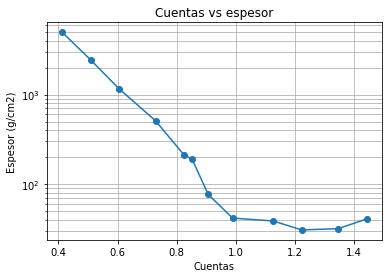

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(df1_p3["espesor (g/cm2)"], df1_p3["cuentas"], "-o")
#plt.legend(loc="top_right")
plt.title("Cuentas vs espesor")
plt.yscale("log")
plt.xlabel("Cuentas")
plt.ylabel("Espesor (g/cm2)")
plt.grid(True, which="both")
plt.show()

In [16]:
alcance = df1_p3["espesor (g/cm2)"].iloc[-5]

TEXT = f"Por inspección visual podemos apreciar que el alcance tiene un valor de ${alcance}g/cm^2$"

md(TEXT)

Por inspección visual podemos apreciar que el alcance tiene un valor de $0.99g/cm^2$

Disponemos de un set de datos que relaciona linealmente el alcance con la energía máxima de las partículas $\beta$ emitidas por diferentes nucleidos

Coeficientes: 1.910
Término independiente: 0.163
Mean Squared Error (MSE): 0.01
R2: 0.99


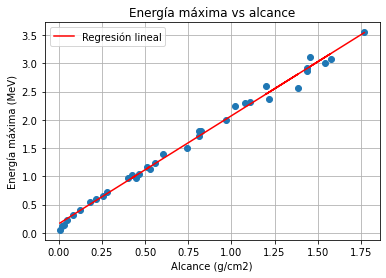

In [17]:
data2_p3 = DATA_PATH + "practica3_energias.csv"
df2_p3 = pd.read_csv(data2_p3)

y = df2_p3["energia maxima (MeV)"].to_numpy()
x = df2_p3["alcance (g/cm2)"].to_numpy()

# Creamos el objeto para regresion lineal
regr = linear_model.LinearRegression()
# Entrenamos nuestro modelo
regr.fit(x.reshape(-1, 1), y)
# Hacemos las predicciones
y_pred = regr.predict(x.reshape(-1, 1))

# Tangente
print("Coeficientes: %.3f" % regr.coef_[0])
# Término independiente
print("Término independiente: %.3f" % regr.intercept_)
# MSE
print("Mean Squared Error (MSE): %.2f" % mean_squared_error(y, y_pred))
# R2, tiende a 1.0
print("R2: %.2f" % r2_score(y, y_pred))


plt.plot(x, y, "o")
plt.plot(x, y_pred, color="red", label="Regresión lineal")
plt.title("Energía máxima vs alcance")
plt.xlabel("Alcance (g/cm2)")
plt.ylabel("Energía máxima (MeV)")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
e_max = regr.coef_[0] * alcance + regr.intercept_

TEXT = f"Con los resultados de la regresión lineal y el valor de alcance obtenido experimenalmente \
        podemos estimar el valor de la energía máxima para nuestra muestra radiactiva de emisión beta es $E_m = {rnd(e_max)}MeV$"

md(TEXT)

Con los resultados de la regresión lineal y el valor de alcance obtenido experimenalmente         podemos estimar el valor de la energía máxima para nuestra muestra radiactiva de emisión beta es $E_m = 2.05MeV$

Podemos comparar estos valores experimentales frente a los resultados dados por las siguientes ecuaciones, conocidas como las ecuaciones de Feather:

$$
E = 1.845D + 0.245 \quad si \quad 0.3<D<1.5 \quad ;  \quad \\
E = 1.918D^{0.72} \quad si \quad 0.012<D<1.3
$$

In [19]:
E_t = 2.28
alcance_feather = (E_t - 0.245)/1.845

TEXT = f"Teniendo en cuenta que nuestra fuente de estroncio 90 tiene una energía máxima teórica de $E_t = {E_t} MeV$, \
         llegamos al resultado de un alcance teórico $D = {rnd(alcance_feather)}g/cm^2$ según la primera fórmula de Feather."

md(TEXT)

Teniendo en cuenta que nuestra fuente de estroncio 90 tiene una energía máxima teórica de $E_t = 2.28 MeV$,          llegamos al resultado de un alcance teórico $D = 1.1g/cm^2$ según la primera fórmula de Feather.

## Conclusiones

Los resultados obtenidos son comparables ya que todos comparten orden de magnitud y primera cifra significativa. Sin embargo, la diferencia entre ambos resultados puede tener varias causas. Algunas de ellas pueden ser errores sistemáticos durante el experimento (debido a mala calibración de los instrumentos, desplazamiento de las muestras, errores en la medición manual), falta de rigurosidad en las estimaciones (la estimación del alcance se ha hecho por inspección visual), falta de datos (más datos supone mayor fiabilidad en experimentos de naturaleza aleatoria), etc. Además, hay que tener en cuenta que estamos comparando valores entre dos métodos que son propiamente experimentales, sin un análisis de confianza no podemos concluir que los valores obtenidos son inconsistentes.

# Detectores de centelleo. Absorción de radiación gamma

Colocamos distintos materiales (aluminio, plomo, hierro) de diferentes espesores entre una muestra radiactiva de $Co^{60}$ y un detector de centelleo. Representamos dichos datos en la siguiente gráfica junto con las regresiones lineales correspondientes. Además presentaremos algunos resultados interesantes requeridos en esta práctica

ALUMINIO
Densidad 2.7 g/cm3
Contaje espesor cero N_0 = 11091 cuentas
Contaje mitad N_12 = 5546 cuentas
Espesor de semirreducción X_12 = 79.54 mm
Coeficiente de absorción lineal mu = 0.087 cm-1
Coeficiente de absorción másico mu_m = 0.032 cm2/g
Número de átomos por cm3: 6.02626116026962e+22
Sección eficaz sigma = 1.4461051514657685e-24 cm2
 
PLOMO
Densidad 11.34 g/cm3
Contaje espesor cero N_0 = 9360 cuentas
Contaje mitad N_12 = 4680 cuentas
Espesor de semirreducción X_12 = 22.54 mm
Coeficiente de absorción lineal mu = 0.308 cm-1
Coeficiente de absorción másico mu_m = 0.027 cm2/g
Número de átomos por cm3: 3.295901361891892e+22
Sección eficaz sigma = 9.332363419312933e-24 cm2
 
HIERRO
Densidad 7.874 g/cm3
Contaje espesor cero N_0 = 10172 cuentas
Contaje mitad N_12 = 5086 cuentas
Espesor de semirreducción X_12 = 30.55 mm
Coeficiente de absorción lineal mu = 0.227 cm-1
Coeficiente de absorción másico mu_m = 0.029 cm2/g
Número de átomos por cm3: 8.491062108378548e+22
Sección eficaz sigma = 2

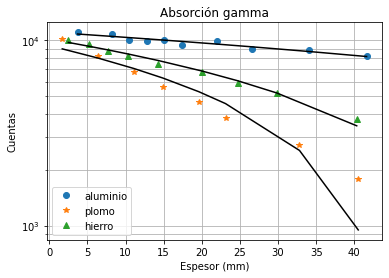

In [20]:
from scipy.constants import Avogadro

# Datos absorción gamma

# fuente: cobalto 60
# tiempo de medida 90s
t_p4 = 90
# Fondo (cuentas)
F = 499
# medidas: practica4_aluminio.csv donde columnas son el espesor (mm) y el número de cuentas
# medidas: practica4_plomo.csv donde columnas son el espesor (mm) y el número de cuentas
# medidas: practica4_hierro.csv donde columnas son el espesor (mm) y el número de cuentas

#elementos = ["aluminio", "plomo", "hierro"]
aluminio = 0
plomo = aluminio + 1
hierro = aluminio + 2

n_elementos = 3

materiales = [[] for _ in range(n_elementos)]
materiales[aluminio] = "aluminio"
materiales[plomo] = "plomo"
materiales[hierro] = "hierro"

densidad = [[] for _ in range(n_elementos)]
densidad[aluminio] = 2.7 # g/cm3
densidad[plomo] = 11.34 # g/cm3
densidad[hierro] = 7.874 # g/cm3

masa_atomica = [[] for _ in range(n_elementos)]
masa_atomica[aluminio] = 26.981539 # unidades
masa_atomica[plomo] = 207.2 # unidades
masa_atomica[hierro] = 55.845 # unidades

# Regresión
x = [[] for _ in range(n_elementos)]
y = [[] for _ in range(n_elementos)]
y_pred = [[] for _ in range(n_elementos)]
regr = [[] for _ in range(n_elementos)]

# Parámetros de interés
N0 = [[] for _ in range(n_elementos)]
N12 = [[] for _ in range(n_elementos)]
X12 = [[] for _ in range(n_elementos)]
absorcion_lineal = [[] for _ in range(n_elementos)]
absorcion_masico = [[] for _ in range(n_elementos)]
atomos_cm3 = [[] for _ in range(n_elementos)]
seccion_eficaz = [[] for _ in range(n_elementos)]

# Plot
symbols = [[] for _ in range(n_elementos)]
symbols[aluminio] = "o"
symbols[plomo] = "*"
symbols[hierro] = "^"

for material in materiales:
    # Carga de datos
    data = DATA_PATH + "practica4_" + material +".csv"
    df = pd.read_csv(data)
    
    # Regresión lineal
    n = materiales.index(material)
    x[n] = df["espesor (mm)"].to_numpy()
    y[n] = df["cuentas"].to_numpy()
    
    regr[n] = linear_model.LinearRegression()
    regr[n].fit(x[n].reshape(-1, 1), y[n])
    y_pred[n] = regr[n].predict(x[n].reshape(-1, 1))
    # Tangente
    #print("Coeficientes: %.3f" % regr.coef_[0])
    # Término independiente
    #print("Término independiente: %.3f" % regr.intercept_)
    # MSE
    #print("Mean Squared Error (MSE): %.2f" % mean_squared_error(y, y_pred))
    # R2, tiende a 1.0
    #print("R2: %.2f" % r2_score(y, y_pred))
    
    # Parámetros de interés
    N0[n] = regr[n].intercept_ # cuentas sin material (espesor cero)
    N12[n] = N0[n] / 2 # cuentas
    X12[n] = (N12[n] - N0[n]) / regr[n].coef_[0] # (mm) espesor cuando cuentas se reduce a mitad
    absorcion_lineal[n] = math.log(2) / (X12[n]/10) # (cm-1) X12 pasado de mm a cm
    absorcion_masico[n] = absorcion_lineal[n] / densidad[n] # cm2/g
    atomos_cm3[n] = densidad[n] * Avogadro / masa_atomica[n] # atomos*cm3
    seccion_eficaz[n] = absorcion_lineal[n] / atomos_cm3[n] # cm2
    print(material.upper())
    print(f"Densidad {densidad[n]} g/cm3")
    print(f"Contaje espesor cero N_0 = {round(N0[n])} cuentas")
    print(f"Contaje mitad N_12 = {round(N12[n])} cuentas")
    print(f"Espesor de semirreducción X_12 = {rnd(X12[n])} mm")
    print(f"Coeficiente de absorción lineal mu = {round(absorcion_lineal[n], 3)} cm-1")
    print(f"Coeficiente de absorción másico mu_m = {round(absorcion_masico[n], 3)} cm2/g")
    print(f"Número de átomos por cm3: {atomos_cm3[n]}")
    print(f"Sección eficaz sigma = {seccion_eficaz[n]} cm2")
    print(" ")
    

    # Plot
    plt.plot(x[n], y[n], symbols[n], label=material)
    plt.plot(x[n], y_pred[n], color="black")
    plt.title("Absorción gamma")
    plt.yscale("log")
    plt.xlabel("Espesor (mm)")
    plt.ylabel("Cuentas")
    
plt.grid(True, which="both")
plt.legend()
plt.show()

Finalmente calcularemos la eficiencia del detector de centelleo

In [21]:
# Datos Cobalto 60
t_p4 = 90
F = 499 # número de cuentas fondo (dato)
L_co = 164463 # número de cuentas (dato)
tasa_recuento_neta_co = (L_co-F)/t_p4 # bq
actividad_inicial_co = 37000 # bq
tiempo_medicion_co = 1.5 # años, septiembre 2010 a marzo 2012
periodo_co = 5.26 # años
lambda_co = np.log(2)/periodo_co # años^(-1)
actividad_corregida_co = actividad_inicial_co*np.e**(-lambda_co*tiempo_medicion_co) # bq
epsilon_co = tasa_recuento_neta_co/actividad_corregida_co


**Fuente: $Co^{60}$**

- Tipo de emisión: emisión $\beta^{-}$ y $\gamma$

- Tiempo de medida: $t=90s$

- Número de cuentas: $L=164463$

- Fondo: $F = 499$

- Tasa de recuento neta: $A'= \frac{(L-F)}{t} = 1821.82 Bq$

- Actividad inicial de la muestra: $A_0 = 1 \mu Ci = 37000 Bq$

- Fecha: septiembre 2010. Tiempo transcurrido hasta marzo 2012 cuando fueron tomadas las medidas: $T_m = 18 meses (1.5 a)$

- Período: $T_{1/2} = 5.26 a -> \lambda = \frac{ln2}{T_{1/2}} = 0.13 a^{-1}$

- Actividad corregida: $A = A_0e^{- \lambda T_m} = 30363 Bq$

- Eficiencia $\epsilon = A'/A = 0.0599$

## Conclusiones

Para las energías de desintegración de la muestra de $Co^{60}$, que son 1.172 MeV y 1.333 MeV, hemos obtenidos los siguientes valores teóricos por inspección visual de las gráficas aportadas: 

**Teórico**

- Aluminio: $\mu = 0.15cm^{-1}$ y $\mu_m = 0.025 cm^2/g$

- Plomo: $\mu = 0.6 cm^{-1}$ y $\mu_m = 0.03 cm^2/g$

Mientras que los valores experimentales han sido

**Experimental**

- Aluminio: $\mu = 0.087cm^{-1}$ y $\mu_m = 0.032 cm^2/g$

- Plomo: $\mu = 0.308 cm^{-1}$ y $\mu_m = 0.027 cm^2/g$

Podemos comprobar que valores teóricos y experimentales son muy similares para el coeficiente de absorción másico (al redondear comparten primera cifra significativa), sin embargo hay notables diferencias para el valor de la absorción lineal. Estas diferencias pueden deberse a diferentes motivos:

- Falta de rigor en los valores teóricos, obtenidos por inspección visual de una gŕafica.

- No se han establecido intervalos de confianza ni medidas de error, ya sean sistemáticos en la medida de espesores, o bien aleatorios referentes a la escasez de medidas. Además no se tienen en cuenta otras fuentes de radiación que también pueden llegar a nuestro detector.

- Al ser una muestra radiativa de emisión $\beta$, es posible que nuestro detector haya capturado parte de éstas partículas, así como los fotones originados por efecto Compton y/o en la aniquilación electrón-positrón que conlleva la creación de pares

La ley de atenuación exponencial de radiación gamma es válida al tratarse de un haz colimado y monoenergético siempre que el material atravesado sea de poco espesor y naturaleza homogénea, condiciones que no podemos garantizar en nuestro experimento ya que

- El haz no ha sido colimado y contiene varias energías.

- No sabemos la pureza y homogeneidad del material blindado.

Dicho esto, a pesar de no poder garantizar la ley de atenuación exponencial, sí es cierto que los datos se ajustan linealmente en una escala semilogarítmica, por lo que en primera aproximación podrían relacionarse a un comportamiento exponencial.

# Determinación experimental del período de una muestra radiactiva

El detector utilizado es un detector de centelleo similar al de la práctica anterior. Se utiliza una muestra de período corto $Ba^{137}$ que se obtiene con un generador de isótopos que contiene $Cs^{137}$ en equilibrio con el $Ba^{137}$

In [22]:
# Datos período de una muestra radiactiva

# tiempo de acumulación: 10s
t_acumulacion = 10
# Fondo
F = 49 # cuentas
# medidas: practica5.csv donde columnas son tiempo (m) y el número de cuentas
data_p5 = DATA_PATH + "practica5.csv"
df1_p5 = pd.read_csv(data_p5)

print(tabulate(df1_p5, headers="keys", tablefmt="presto"))

    |   tiempo (m) |   cuentas
----+--------------+-----------
  0 |            0 |     10479
  1 |            1 |      6934
  2 |            2 |      5998
  3 |            3 |      4169
  4 |            4 |      3374
  5 |            5 |      2636
  6 |            6 |      1680
  7 |            7 |      1537
  8 |            8 |      1152
  9 |            9 |       737
 10 |           10 |       665
 11 |           11 |       488
 12 |           12 |       436


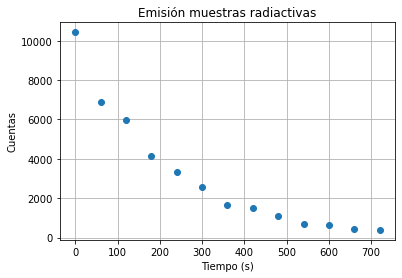

In [23]:
df1_p5["tiempo (s)"] = df1_p5["tiempo (m)"] * 60
df1_p5["cuentas"] = df1_p5["cuentas"] - F

plt.plot(df1_p5["tiempo (s)"], df1_p5["cuentas"], "o")
plt.title("Emisión muestras radiactivas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Cuentas")
plt.grid(True)
plt.show()

Aplicando logaritmos a la ecuación de la actividad de una muestra radiactiva tenemos

$$
A(t) = A_0e^{-\lambda t} \quad -> \quad Ln (A(t)) = -\lambda t +Ln(A_0)
$$

Así la contstante de desintegración será la pendiente de una regresión lineal. Por otro lado el período de semidesintegración es

$$
T_{1/2} = \frac{Ln(2)}{\lambda}
$$

Coeficientes: -0.005
Término independiente: 9.194
Mean Squared Error (MSE): 0.01
R2: 0.99


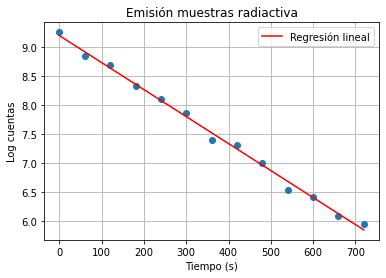

In [24]:
y = df1_p5["cuentas"].to_numpy()
y = np.log(y)
x = df1_p5["tiempo (s)"].to_numpy()

# Creamos el objeto para regresion lineal
regr = linear_model.LinearRegression()
# Entrenamos nuestro modelo
regr.fit(x.reshape(-1, 1), y)
# Hacemos las predicciones
y_pred = regr.predict(x.reshape(-1, 1))

# Tangente
print("Coeficientes: %.3f" % regr.coef_[0])
# Término independiente
print("Término independiente: %.3f" % regr.intercept_)
# MSE
print("Mean Squared Error (MSE): %.2f" % mean_squared_error(y, y_pred))
# R2, tiende a 1.0
print("R2: %.2f" % r2_score(y, y_pred))


plt.plot(x, y, "o")
plt.plot(x, y_pred, color="red", label="Regresión lineal")
plt.title("Emisión muestras radiactiva")
plt.xlabel("Tiempo (s)")
plt.ylabel("Log cuentas")
plt.grid(True)
plt.legend()
plt.show()

In [25]:
lamb = round(abs(regr.coef_[0]), 3)

TEXT = f"Por lo tanto tenemos que la constante es $\lambda = {lamb}$ 1/s"

md(TEXT)

Por lo tanto tenemos que la constante es $\lambda = 0.005$ 1/s

In [26]:
T12 = rnd(math.log(2) / lamb)

TEXT = f"Siendo el período de semidesintegración {T12} s"

md(TEXT)

Siendo el período de semidesintegración 138.63 s

## Conclusiones

Hemos comprobado que nuestros datos cumplen una ley de decaimiento exponencial, calculando así la constante de desintegración y el correspondiente período de semidesintegración. Al tener un período de semidesintegración un valor entorno a 2.3 minutos no podemos tomar medidas de tiempo mayores. Si midiésemos cada 5 minutos, por ejemplo, transcurriría casi dos veces el período de semidesintegración entre medidas, reduciéndose casi dos veces a la mitad la población de núcleos.

# Espectrometría de partículas alfa y beta. Absorción de partículas alfa

Contamos con un detector de barrera de superficie con el que detectamos partículas alfa provenientes de una fuente ($Am^{241}(\alpha)$, $Sr^{90}(\beta)$, $Cs^{137}(\beta; CI)$) radiactiva mientras variamos la distancia. No tendremos medidas de fondo por ser prácticamente despreciable.

In [27]:
# Datos período de una muestra radiactiva

# tiempo de acumulación: 300s
t_acumulacion = 300
# medidas: practica6.csv donde columnas son distancia (cm) y el número de cuentas
data_p6 = DATA_PATH + "practica6.csv"
df1_p6 = pd.read_csv(data_p6)
df1_p6["bq"] = df1_p6["area (cuentas)"] / t_acumulacion

print(tabulate(df1_p6, headers="keys", tablefmt="presto", showindex=False))

   distancia (cm) |   area (cuentas) |        bq
------------------+------------------+-----------
              1   |            61281 | 204.27
              1.5 |            36195 | 120.65
              2   |            24549 |  81.83
              2.5 |            13676 |  45.5867
              3   |             9207 |  30.69
              3.5 |              563 |   1.87667


Coeficientes: -75.319
Término independiente: 250.286
Mean Squared Error (MSE): 332.39
R2: 0.93


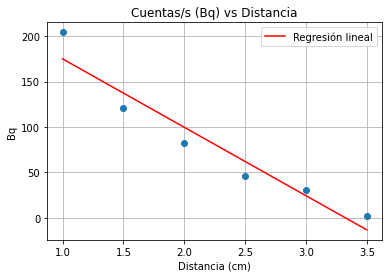

In [28]:
y = df1_p6["bq"].to_numpy()
x = df1_p6["distancia (cm)"].to_numpy()

# Creamos el objeto para regresion lineal
regr = linear_model.LinearRegression()
# Entrenamos nuestro modelo
regr.fit(x.reshape(-1, 1), y)
# Hacemos las predicciones
y_pred = regr.predict(x.reshape(-1, 1))

# Tangente
print("Coeficientes: %.3f" % regr.coef_[0])
# Término independiente
print("Término independiente: %.3f" % regr.intercept_)
# MSE
print("Mean Squared Error (MSE): %.2f" % mean_squared_error(y, y_pred))
# R2, tiende a 1.0
print("R2: %.2f" % r2_score(y, y_pred))


plt.plot(x, y, "o")
plt.plot(x, y_pred, color="red", label="Regresión lineal")
plt.title("Cuentas/s (Bq) vs Distancia")
plt.xlabel("Distancia (cm)")
plt.ylabel("Bq")
plt.grid(True)
plt.legend()
plt.show()

In [29]:
alcance = rnd(-regr.intercept_ / regr.coef_[0])

TEXT = f"Mediante un ajuste lineal podemos extrapolar el alcance (punto de corte con eje X), \
         que toma un valor de {alcance} cm."

md(TEXT)

Mediante un ajuste lineal podemos extrapolar el alcance (punto de corte con eje X),          que toma un valor de 3.32 cm.

In [30]:
# Datos alfa
area_t = 204.27 # bq
actividad_inicial_alfa = 37000 # bq
tiempo_medicion_alfa = 24 # años, septiembre 2010 a marzo 2012
periodo_alfa = 458 # años
lambda_alfa = np.log(2)/periodo_alfa # años^(-1)
actividad_corregida_alfa = actividad_inicial_alfa*np.e**(-lambda_alfa*tiempo_medicion_alfa) # bq
epsilon_alfa = area_t/actividad_corregida_alfa

**Eficiencia del detector para $\alpha$**

Se toma el valor de lárea cuando la muestra está lo más cercana posible al detector, es decir, a 1cm.

- Área/t: $A' = 204.27$ Bq

- Actividad inicial de la muestra: $A_0 = 37$ kBq

- Fecha: año 1988. Tiempo transcurrido entre 1988 y 2012: 24 años. $T_{1/2} = 458 a -> \lambda = \frac{ln2}{T_{1/2}} = 0.0015 a^{-1}$

- Actividad corregida: $A = A_0e^{- \lambda T_m} = 35680.19 Bq$

- Eficiencia $\epsilon = A'/A = 0.0057$

In [31]:
# Datos beta
area_t = 370.56 # bq
actividad_inicial_beta = 37000 # bq
tiempo_medicion_beta = 24 # años, septiembre 2010 a marzo 2012
periodo_beta = 28.1 # años
lambda_beta = np.log(2)/periodo_beta # años^(-1)
actividad_corregida_beta = actividad_inicial_beta*np.e**(-lambda_beta*tiempo_medicion_beta) # bq
epsilon_alfa = area_t/actividad_corregida_beta

**Eficiencia del detector para $\beta$**

Se toma el valor del área para el espectro del $Sr^{90}$

- Área/t: $A' = 370.56$ Bq

- Actividad inicial de la muestra: $A_0 = 37$ kBq

- Fecha: año 1988. Tiempo transcurrido entre 1988 y 2012: 24 años. $T_{1/2} = 28.1 a -> \lambda = \frac{ln2}{T_{1/2}} = 0.024 a^{-1}$

- Actividad corregida: $A = A_0e^{- \lambda T_m} = 20468.88 Bq$

- Eficiencia $\epsilon = A'/A = 0.018$

## Conclusiones

Aunque el espectro del $Am^{241}$ tiene forma de acampanada, si nuestro detector tuviera mayor resolución realmente deberíamos observar picos energéticos de valor 5545, 5513, 5486, 5443 y 5388 keV.

Una de las curiosidades de las partículas $\alpha$ es que su alcance en aire es del orden de unos pocos centímetros, con lo cual serían indetectables en fuentes alejadas. En particular, con los datos de este ejercicio obtenemos que serían indetectables a distancias mayores a 3.32 cm.

Las partículas $\beta$ tienen un espectro continuo porque en cada proceso existe un reparto de energía entre el electrón y el antineutrino. La forma del espectro parte de energía cero, aumenta y disminuye hasta llegar un punto en el que la energía cinética máxima del electrón es igual a la diferencia de masas entre el estado inicial y final, que corresponde al caso en el que la energía cinética del antineutrino es cero.

En cuanto a los espectros podemos decir que el espectro del $Sr^{90}$ tiene dos componentes, una son las betas del decaimineto de $Sr^{90}$ a $Y^{90}$ y otra debida al decaimiento de $Y^{90}$ a $Zr^{90}$. El filtro de plomo mantiene la forma del espectro beta aunque reduciendo su área en un 90%. El espectro del $Cs^{137}$ tiene la misma forma que los anteriores espectros a diferencia de dos picos debidos a efectos de reconversión interna.

Finalmente, el contador G-M es mejor porque resultó tener una eficiencia del 11%, mientras que éste es de 1.8%.

# Espectroscopía gamma con detectores de INA(TL)

Los detectores de NaI(Tl) son detectores de centelleo, en los que la sustancia luminiscente es NaI(Tl). Para obtener los espectros de muestras emisoras gamma se utiliza un sistema de acumulación de impulsos similar al de la práctica anterior.

Una vez medido el fondo, y tras calibrar el detector con una muestra de $Eu^{152}$, pasaremos a determinar su eficiencia y resolución.

In [32]:
# Datos gamma par fondo, calibración y eficiencia
actividad_inicial_gamma = 40200 # bq
tiempo_medicion_gamma = 11 # años, septiembre 2010 a marzo 2012
periodo_gamma = 13.52 # años
lambda_gamma = np.log(2)/periodo_gamma # años^(-1)
actividad_corregida_gamma = actividad_inicial_gamma*np.e**(-lambda_gamma*tiempo_medicion_gamma) # bq

**Calibración**

- Primer pico: canal $c_1 = 38.78$; energía $E = 0.122$ MeV

- Segundo pico: canal $c_2 = 400.92$; energía $E = 1.41$ MeV

**Eficiencia**

- Actividad inicial de la muestra $A_0 = 40.2$ kBq

- Fecha: año 2001. Tiempo transcurrido entre 2001 y 2012: 11 años. $T_{1/2} = 13.52 a -> \lambda = \frac{ln2}{T_{1/2}} = 0.051 a^{-1}$

- Actividad corregida: $A = A_0e^{- \lambda T_m} = 22872.05 Bq$

- Eficiencia $\epsilon (E) = \frac{A_f}{AC_r}$, siendo $A_f$ el área del fotopico (Bq)

In [33]:
# Datos espectroscopía gamma eficiencia

# medidas: practica7_eficiencia.csv donde columnas son energía (MeV), el área de pico (Bq) y el coeficiente de ramificación para cada energía
data_p7 = DATA_PATH + "practica7_eficiencia.csv"
df1_p7 = pd.read_csv(data_p7)
df1_p7["eficiencia"] = round(df1_p7["area pico (Bq)"] / (actividad_corregida_gamma*df1_p7["Cr"]), 3)
df1_p7["eficiencia (%)"] = rnd(df1_p7["eficiencia"] * 100)

print(tabulate(df1_p7, headers="keys", tablefmt="presto", showindex=False))

   energia (MeV) |   area pico (Bq) |    Cr |   eficiencia |   eficiencia (%)
-----------------+------------------+-------+--------------+------------------
           0.04  |           1680.1 | 0.567 |        0.13  |             13
           0.122 |            584.8 | 0.307 |        0.083 |              8.3
           0.244 |             98.7 | 0.079 |        0.055 |              5.5
           0.344 |            303.1 | 0.272 |        0.049 |              4.9
           0.78  |             56.3 | 0.133 |        0.019 |              1.9
           0.96  |             28.1 | 0.145 |        0.008 |              0.8
           1.41  |             22.6 | 0.214 |        0.005 |              0.5


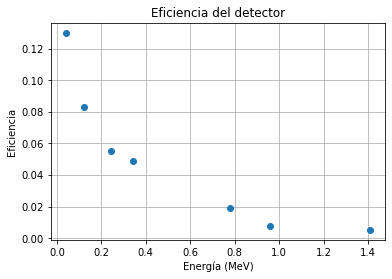

In [34]:
plt.plot(df1_p7["energia (MeV)"], df1_p7["eficiencia"], "o")
plt.title("Eficiencia del detector")
plt.xlabel("Energía (MeV)")
plt.ylabel("Eficiencia")
plt.grid(True)
plt.show()

**Resolución**

In [35]:
# Datos espectroscopía gamma resolucion

# medidas: practica7_resolucion.csv donde columnas son fuente radiactiva, energía (MeV) y anchura a semialtura (MeV)
data2_p7 = DATA_PATH + "practica7_resolucion.csv"
df2_p7 = pd.read_csv(data2_p7)
df2_p7["resolucion (%)"] = round(100 * df2_p7["anchura semialtura (MeV)"] / df2_p7["energia (MeV)"])

print(tabulate(df2_p7, headers="keys", tablefmt="presto", showindex=False))

 fuente   |   energia (MeV) |   anchura semialtura (MeV) |   resolucion (%)
----------+-----------------+----------------------------+------------------
 Cs137    |           0.667 |                      0.057 |                9
 Co60     |           1.17  |                      0.067 |                6
 Co60     |           1.32  |                      0.073 |                6
 Na22     |           1.26  |                      0.08  |                6
 Na22     |           0.51  |                      0.046 |                9
 Zn65     |           1.12  |                      0.073 |                7
 Mn54     |           0.834 |                      0.062 |                7


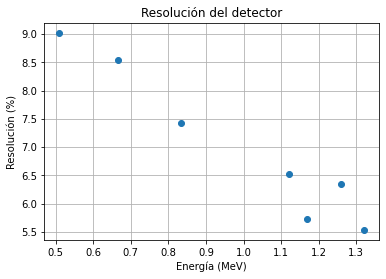

In [36]:
# Calculamos resolución otra vez para mayor detalle en la gráfica
df2_p7["resolucion (%)"] = 100 * df2_p7["anchura semialtura (MeV)"] / df2_p7["energia (MeV)"]

plt.plot(df2_p7["energia (MeV)"], df2_p7["resolucion (%)"], "o")
plt.title("Resolución del detector")
plt.xlabel("Energía (MeV)")
plt.ylabel("Resolución (%)")
plt.grid(True)
plt.show()

Una vez caracterizado el detector, pasaremos estudiar el espectro de distintos isótopos

$Cs^{137}$

- Energía del borde Compton del espectro: 0.468 MeV

- Energía del borde Compton del espectro teórico: 0.478 MeV

- Energía del pico de retrodispersión: 0.201 MeV

- Energía del pico de retrodispersión teório: 0.184 MeV

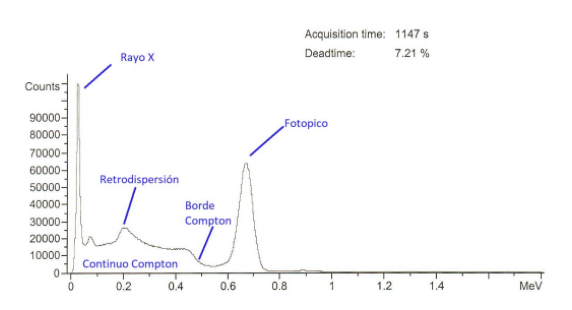

In [37]:
IMAGES = "images/practica7/"

cs137 = IMAGES + "cs137.png"
cs137 = cv2.imread(cs137)

plt.figure(figsize = (10, 10))
plt.axis("off")
plt.imshow(cs137)
plt.show()

$Co^{60}$

- Energía del borde Compton del espectro: 0.966 MeV

- Energía del borde Compton del espectro teórico: 0.962 MeV y 1.119 MeV

- Energía del pico de retrodispersión: 0.233 MeV

- Energía del pico de retrodispersión teório: 0.210 MeV y 0.214 MeV

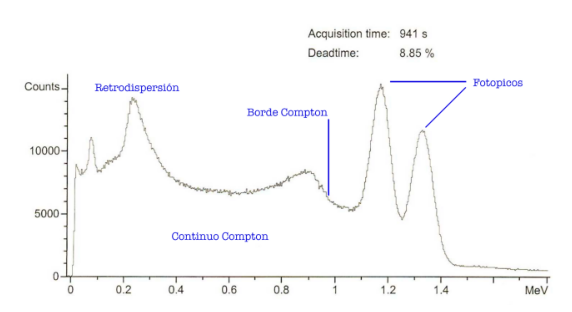

In [38]:
co60 = IMAGES + "co60.png"
co60 = cv2.imread(co60)

plt.figure(figsize = (10, 10))
plt.axis("off")
plt.imshow(co60)
plt.show()

$Na^{22}$

- Energía del borde Compton del espectro: 1.040 MeV

- Energía del borde Compton del espectro teórico: 1.063 MeV

- Energía del pico de retrodispersión: 0.190 MeV

- Energía del pico de retrodispersión teório: 0.213 MeV

**Aniquilación**

- Energía del borde Compton del espectro (aniquilación): 0.336 MeV

- Energía del borde Compton del espectro teórico (aniquilación): 0.341 MeV

- Energía del pico de retrodispersión (aniquilación): No se ve

- Energía del pico de retrodispersión teório (aniquilación): 0.170 MeV

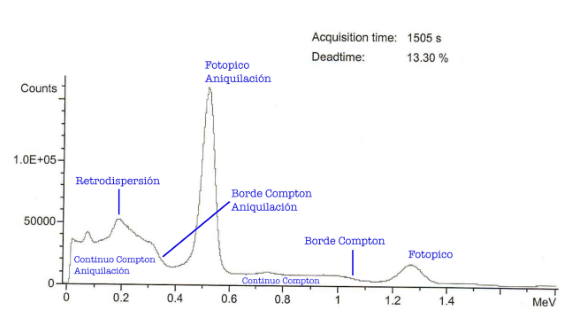

In [39]:
na22 = IMAGES + "na22.png"
na22 = cv2.imread(na22)

plt.figure(figsize = (10, 10))
plt.axis("off")
plt.imshow(na22)
plt.show()

$Zn^{65}$

- Energía del borde Compton del espectro: 0.909 MeV

- Energía del borde Compton del espectro teórico: 0.906 MeV

- Energía del pico de retrodispersión: 0.229 MeV

- Energía del pico de retrodispersión teório: 0.208 MeV

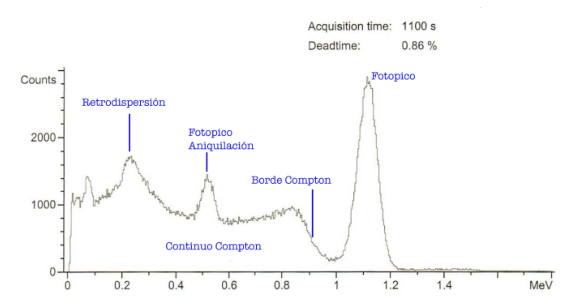

In [40]:
zn65 = IMAGES + "zn65.png"
zn65 = cv2.imread(zn65)

plt.figure(figsize = (10, 10))
plt.axis("off")
plt.imshow(zn65)
plt.show()

$Mn^{54}$

- Energía del borde Compton del espectro: 0.635 MeV

- Energía del borde Compton del espectro teórico: 0.646 MeV

- Energía del pico de retrodispersión: 0.212 MeV

- Energía del pico de retrodispersión teório: 0.196 MeV

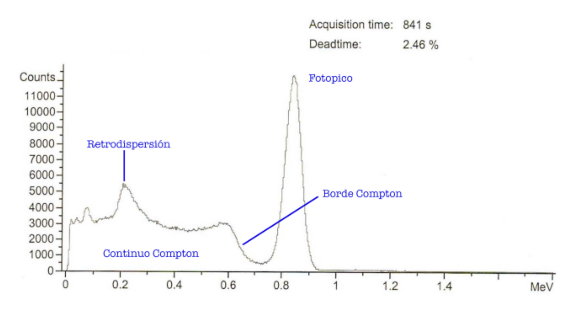

In [41]:
mn54 = IMAGES + "mn54.png"
mn54 = cv2.imread(mn54)

plt.figure(figsize = (10, 10))
plt.axis("off")
plt.imshow(mn54)
plt.show()

Por otro lado, acumulamos durante un tiempo una muestra de $Co^{60}$ de actividad conocida y, durante el mismo tiempo, otra muestra de $Co^{60}$ de actividad desconocida. Comparando los fotopicos se obtendrá la actividad desconocida.

In [42]:
# Datos gamma par fondo, calibración y eficiencia
actividad_inicial_conocida = 37000 # bq
tiempo_medicion_conocida = 3 # años, enero 2009 a marzo 2012
periodo_conocida = 5.26 # años
lambda_conocida = np.log(2)/periodo_conocida # años^(-1)
actividad_corregida_conocida = actividad_inicial_conocida*np.e**(-lambda_conocida*tiempo_medicion_conocida) # bq

pico1_conocida = 268.19
pico2_conocida = 246.08

pico1_desconocida = 366.24
pico2_desconocida = 340.33

actividad_desconocida = (actividad_corregida_conocida / 2) * ((pico1_desconocida/pico1_conocida) + (pico2_desconocida/pico2_conocida))

**Actividad conocida $Co^{60}$**

- Actividad inicial de la muestra $A_0 = 1 \mu Ci = 37000 Bq$

- Fecha: año 2009. Tiempo transcurrido entre 2009 y 2012: 3 años. $T_{1/2} = 5.26 a -> \lambda = \frac{ln2}{T_{1/2}} = 0.13 a^{-1}$

- Actividad corregida: $A = A_0e^{- \lambda T_m} = 24917.91 Bq$

- Área del primer pico: 268.19 Bq

- Área del segundo pico: 246.08 Bq

**Actividad desconocida $Co^{60}$**

- Área del primer pico: 366.24 Bq

- Área del segundo pico: 340.33 Bq

- Actividad $A = A_0e^{- \lambda T_m} \frac{\frac{366.24}{268.19} + \frac{340.33}{246.08}}{2} = 34244.74 Bq$

Para finalizar, introducimos una muestra de elemento desconocido y almacenamos datos hasta tener una buena estadística. Tenemos 4 fotopicos con energías 0.511, 0.662, 1.17 y 1.33 MeV. Con éstos datos concluimos que se trata de una combinación de  $Co^{60}, Cs^{137}$ y $Na^{22}$

## Conclusiones

En esta práctica hemos calculado la eficiencia y la resolución del detector. Podemos ver que la eficiencia decae cuánto mayor es la energía de los fotones, pues no logran interactuar con el detector. La resolución decae también, pero en este caso el decaimiento es lineal.

El espectro de la radiación gamma es discreto, pues como hemos visto durante el desarrollo del ejercicio, cada energía (discreta) corresponde con los fotopicos observados. Junto a cada pico de energía vemos la correspondiente región continua asociada al efecto Compton. A vistas de los resultados nada parece indicar una discordancia entre los resultados teóricos y experimentales. A este respecto cabe mencionar los picos de 0.511 MeV, los cuales surgen por la aniquilación de los positrones emitidos por algunas muestras, que dan lugar a fotones de dicha energía. Por ejemplo ocurre con el $Na^{22}$ aunque no con el $Zn{65}$. Cabe entonces preguntarse por qué el $Zn{65}$ tiene un pico en 0.511 MeV... la razón es que el $Zn{65}$ es capaz de emitir energía mayor a 1.022 MeV, con lo que puede dar lugar a la creación de pares con energía igual a 0.511 MeV.

Una obervación importante es que en algunos espectros aparecen picos correspondientes a emisión de rayos X. Esto ocurre debido a procesos de conversión interna donde la reordenación electrónica da lugar a emisión de rayos X.

Para finalizar, recalcar que la calibración del espectro de energías es un proceso fundamental para identificar la posición de cada pico en nuestra escala de energías. Esto lo hemos hecho comparando todos los picos del espectro con los del $Eu^{152}$.

A modo de curiosidad, tan solo decir que aunque en este experimento se ha medido el espectro gamma de una serie de elementos en el laboratorio, también resultaría útil para medir la radiación gamma que nos llega desde el exterior en forma de rayos cósmicos, o por ejemplo podríamos medir la radiactividad de un plátano (por su contenido en pótasio $K^{40}$) o bien la radiactividad cerca de una central nuclear ($U^{238}$) y/o algunas tierras raras presentes de manera natural en el ambiente o en particular en la fabricación de lámparas elécticas, como son el torio ($Th^{232}$).